# Data Clean and Feature Engineering
1. `train_0N.csv` and `test_0N.csv` came from Andrew's notebook after remove all the `NaN` in the files.
2. The following processes were performed:
    - Remove irrelevant cols
    - Remove low variance vars
    - Merge high colinearity vars
    - Remove outliers
    - Log tranform on all high scewness items
    - Consistent ordinal mapping with know ordinal cols
    - Generate numerical data to some nominal cols
    - Dummy replacement on pure nominal cols
    - Feature engineering in a conservative way. 

In [173]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import feature_selection
from sklearn import decomposition
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [174]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Initial look and fix some small errors.

Skewness is:      1.883
Kurtosis is:      6.536
Skewness is:      0.121
Kurtosis is:      0.810


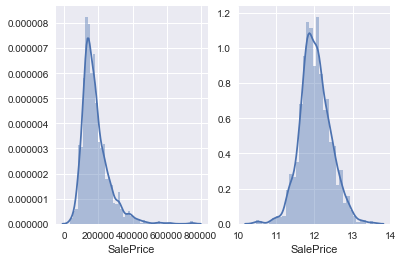

In [175]:
# import NA free data
train = pd.read_csv('./data/train_0N.csv')
test = pd.read_csv('./data/test_0N.csv')
# drop irrelevant cols
train.drop(['Unnamed: 0', 'Id'], axis = 1, inplace = True)
test.drop(['Unnamed: 0', 'Id'], axis = 1, inplace = True)

# small fix
mask = test.MSZoning == 'C (all)'
test.loc[mask, 'MSZoning'] = 'C'

# plot frame
plt.figure()
# plot see the sale price trend
plt.subplot(1, 2, 1)
sns.distplot(train['SalePrice'])
# we can see a positive skewness
print("Skewness is: {0:10.3f}\nKurtosis is: {1:10.3f}"
      .format(train['SalePrice'].skew(), 
              train['SalePrice'].kurt()))
# log the skwed data
tempLogResult = np.log1p(train["SalePrice"])
# plot see the sale price trend
plt.subplot(1, 2, 2)
sns.distplot(tempLogResult)
# we can see a positive skewness
print("Skewness is: {0:10.3f}\nKurtosis is: {1:10.3f}"
      .format(tempLogResult.skew(), 
              tempLogResult.kurt()))

# This log transfer will be performed later on all numberic cols with large skewness.
# The purpose is to increase linearity
# prediction must be revesed back!!!
numericColsSkew = train.select_dtypes(include=[np.number]).skew()
highSkewCol = numericColsSkew[numericColsSkew > 0.75].index
# the above save for later

# To reverse back
def logToNormal(logValue):
    pass
    # develop later

## Remove low variance features. 

In [176]:
# Refer to Shu's code and remove low variance cols
toBeRemLowVar = ['Street', 'Utilities', 'Condition2', 'RoofMatl', 
                 'LowQualFinSF', 'X3SsnPorch', 'PoolArea', 'PoolQC', 'MiscVal']

# func to remove list
def removeDueShuCode(df, toBeRemLowVar):
    for col in toBeRemLowVar:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    else:
        pass
# Remove
removeDueShuCode(train, toBeRemLowVar)
removeDueShuCode(test, toBeRemLowVar)

# check if any dataframe contains NA, if does return the columns. 
def checkNull(df):
    if not isinstance(df, pd.DataFrame):
        return('No dataframe find!')
    if df.isnull().sum().sum() != 0:
        byCol = df.isnull().sum()
        return(byCol[byCol!=0])
    else:
        return ('The dataframe is NA free. Contains {0} rows with {1} attributes'.format(df.shape[0], df.shape[1]))
    
    
# check train & test
# If any data is not NA free: revise imputation step before proceed any further. 
print('Train: {0}\nTest: {1}'.format(checkNull(train),checkNull(test)))


# check num and cat col counts
def colTypeCount(df):
    if not isinstance(df, pd.DataFrame):
        return('No dataframe find!')
    lenNum = df.select_dtypes(include=[np.number]).shape[1]
    return ('has {0} num cols, and {1} cat cols'.format(lenNum, df.shape[1] - lenNum))

# check train & test
print('Train: {0}\nTest: {1}'.format(colTypeCount(train),colTypeCount(test)))


Train: The dataframe is NA free. Contains 1460 rows with 72 attributes
Test: The dataframe is NA free. Contains 1459 rows with 71 attributes
Train: has 34 num cols, and 38 cat cols
Test: has 33 num cols, and 38 cat cols


In [177]:
# drop columns with variance lower than threshold
def lowVarCol(df, threshold = 1.0):
    numCols = df.select_dtypes(include=[np.number])
    var = numCols.var()
    lowVar = var[var<=threshold]
    return var, lowVar

# analyze train 
varStats, lowVar = lowVarCol(train, 1.0)

print (lowVar)
# we can see most var are above 1.0
#print (varStats)


BsmtFullBath    0.269268
BsmtHalfBath    0.057003
FullBath        0.303508
HalfBath        0.252894
Bedroom         0.665494
Kitchen         0.048549
Fireplaces      0.415595
GarageCars      0.558480
dtype: float64


In [178]:
# Merge BsmtBath = BsmtFullBath + BsmtHalfBath*0.5 
# Merge Bath = FullBath + HalfBath*0.5
# shape after merge 1460, 78 (from 80)
def mergeBathAndBaseBath(df):
    if {'BsmtBath', 'Bath'}.issubset(df.columns):
        pass
    else:
        df['BsmtBath'] = df['BsmtFullBath'] + df['BsmtHalfBath'] * 0.5
        df.drop(['BsmtFullBath','BsmtHalfBath'], axis=1, inplace=True)
        df['Bath'] = df['FullBath'] + df['HalfBath'] * 0.5
        df.drop(['FullBath','HalfBath'], axis=1, inplace=True)

mergeBathAndBaseBath(train)
mergeBathAndBaseBath(test)

## Collinearity check and remove.

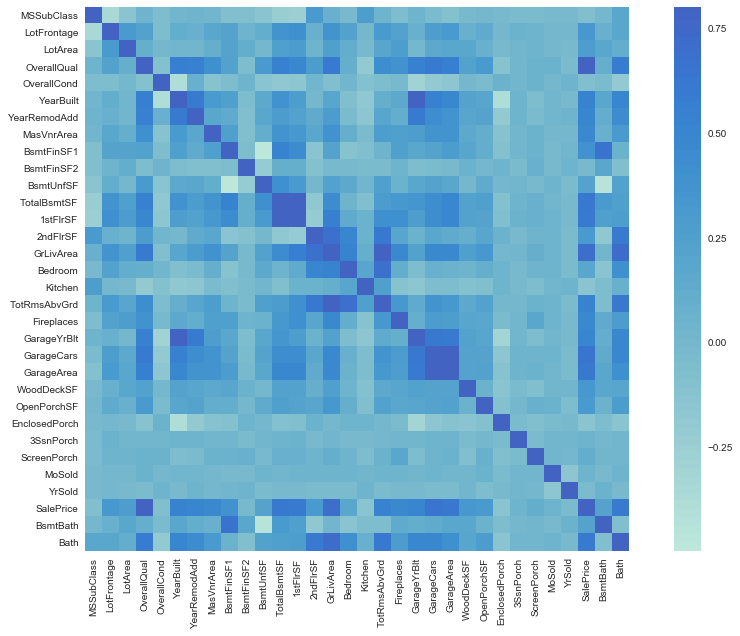

In [179]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(corrmat, vmax=.8, square=True, center=2)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [180]:
print(corrmat['1stFlrSF']['TotalBsmtSF'])
print(corrmat['GarageArea']['GarageCars'])
# Refer collinear vars
toBeRemCollinear = ['1stFlrSF', 'GarageCars']
def removeCollinear(df, toBeRemCollinear):
    for col in toBeRemCollinear:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
        else:
            pass
# Remove
removeCollinear(train, toBeRemCollinear)
removeCollinear(test, toBeRemCollinear)

0.8195299750050355
0.8824754142814603


## Outlier Analysis

![outiers](https://i2.wp.com/nycdatascience.com/blog/wp-content/uploads/2017/11/outliers.png?ssl=1)

In [181]:
# Remove outliers, the very obvious 2.
train = train.drop(train[(train.GrLivArea > 4000) & (train['SalePrice']<300000)].index)

# perform log transform and remove data points beyond +-3STD 
tempCopy = train
tempNumImage = tempCopy.select_dtypes(include=[np.number])

tempNumImageLog = np.log1p(tempNumImage)

# Get raw outlier analysis result
toBeRemoveIndexLog =(np.abs(tempNumImageLog - tempNumImageLog.mean()) > 3 * tempNumImageLog.std()).sum(axis = 1)

# Set sensitivety, the entry is a outlier in 1-4 cols.
for i in range(0,5):
    totalToBeRemove = (toBeRemoveIndexLog>i).sum()
    print('For level {0} sensitivity, we will need to remove {1} data points.'.format(i, totalToBeRemove))

For level 0 sensitivity, we will need to remove 432 data points.
For level 1 sensitivity, we will need to remove 132 data points.
For level 2 sensitivity, we will need to remove 43 data points.
For level 3 sensitivity, we will need to remove 10 data points.
For level 4 sensitivity, we will need to remove 1 data points.


In [182]:
# Considering we only have 1458 data points, anything beyond level 2 is unaffordable (lost 3% data points at level 2)
maskIndex = toBeRemoveIndexLog>2
print(train.shape)
train = train[~maskIndex].copy()
print(train.shape)

(1458, 68)
(1415, 68)


## Start on categorical

In [183]:
# Now works on the categorical cols
def colByType(df): 
    totalCol = list(df.columns)
    numericalCol = list(df.describe().columns)
    categoricalCol = [x for x in totalCol if x not in numericalCol]
    return numericalCol, categoricalCol

numTrain, catTrain = colByType(train)
numTest, catTest = colByType(test)

# start point
print('Before change, we have {0} cat cols for train/test'.format(len(catTrain)))

# general check
# for col in catTrain:
#     print (col, train[col].unique())


Before change, we have 38 cat cols for train/test


### Swap ordinal to levels

In [184]:
# Upon read data_description.txt, the ordinal cols are

ordCols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
          'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond',
          'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'Fence', 
          'CentralAir']
# Testing
# for i in ordCols:
#      print (i, train[i].unique())

codeToLevelDict = {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5,
             "Mn": 2, "Av": 3, 
             "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6,
             "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8,
             "RFn": 2, "Fin": 3,
             "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4,
             "N": 0, "Y": 1,
            }


def codeToLevel(df, ordCols, codeToLevelDict):
    for col in ordCols:
        if np.issubdtype(df[col].dtype, np.number):
            pass
        else:
            df[col] = df[col].map(codeToLevelDict).astype(int)
            
# Convert
codeToLevel(train, ordCols, codeToLevelDict)
codeToLevel(test, ordCols, codeToLevelDict)


# Report
numTrainNew, catTrainNew = colByType(train)
numTestNew, catTestNew = colByType(test)
print('{0} cat cols in train/test,\n{1} are ordinal data, \nafter convert,\
now train/test has {2} cate cols, \nwhich are nominial cols.'.format(len(catTrain), len(ordCols), len(catTestNew)))



38 cat cols in train/test,
15 are ordinal data, 
after convert,now train/test has 23 cate cols, 
which are nominial cols.


In [185]:
# general check
# for col in catTestNew:
#     print (col, train[col].unique())

### Neighborhood Special treatment: location location location

In [186]:
# Neighborhood
neighborhoodPrice = train["SalePrice"].groupby(train["Neighborhood"]).median().sort_values()
neighborhoodMap = dict(zip(list(neighborhoodPrice.index), list(neighborhoodPrice)))
# modified code to level
def codeToLevelFloat(df, ordCols, codeToLevelDict):
    for col in ordCols:
        if np.issubdtype(df[col].dtype, np.number):
            pass
        else:
            df[col] = df[col].map(codeToLevelDict).astype(float)
            
# Convert
codeToLevelFloat(train, ordCols = ["Neighborhood"], codeToLevelDict = neighborhoodMap)
codeToLevelFloat(test, ordCols = ["Neighborhood"], codeToLevelDict = neighborhoodMap)



### Now establish a meaningful way to convert the rest

In [187]:
numTrainNew, catTrainNew = colByType(train)
numTestNew, catTestNew = colByType(test)
for col in catTestNew:
    print (col, train[col].unique())
len(catTestNew)

MSZoning ['RL' 'RM' 'C' 'FV' 'RH']
Alley ['No' 'Grvl' 'Pave']
LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope ['Gtl' 'Mod' 'Sev']
Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
BldgType ['1Fam' '2fmCon' 'TwnhsE' 'Duplex' 'Twnhs']
HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
Exterior1st ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'Stucco' 'AsbShng' 'BrkComm' 'Stone' 'ImStucc' 'CBlock']
Exterior2nd ['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock']
MasVnrType ['BrkFace' 'None' 'Stone' 'BrkCmn' 'No']
Foundation ['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'Stone']
BsmtExposure ['No' 'Gd' 'Mn' 'Av']
Heating ['GasA' 'GasW' 'Grav' 'Wall' 'O

22

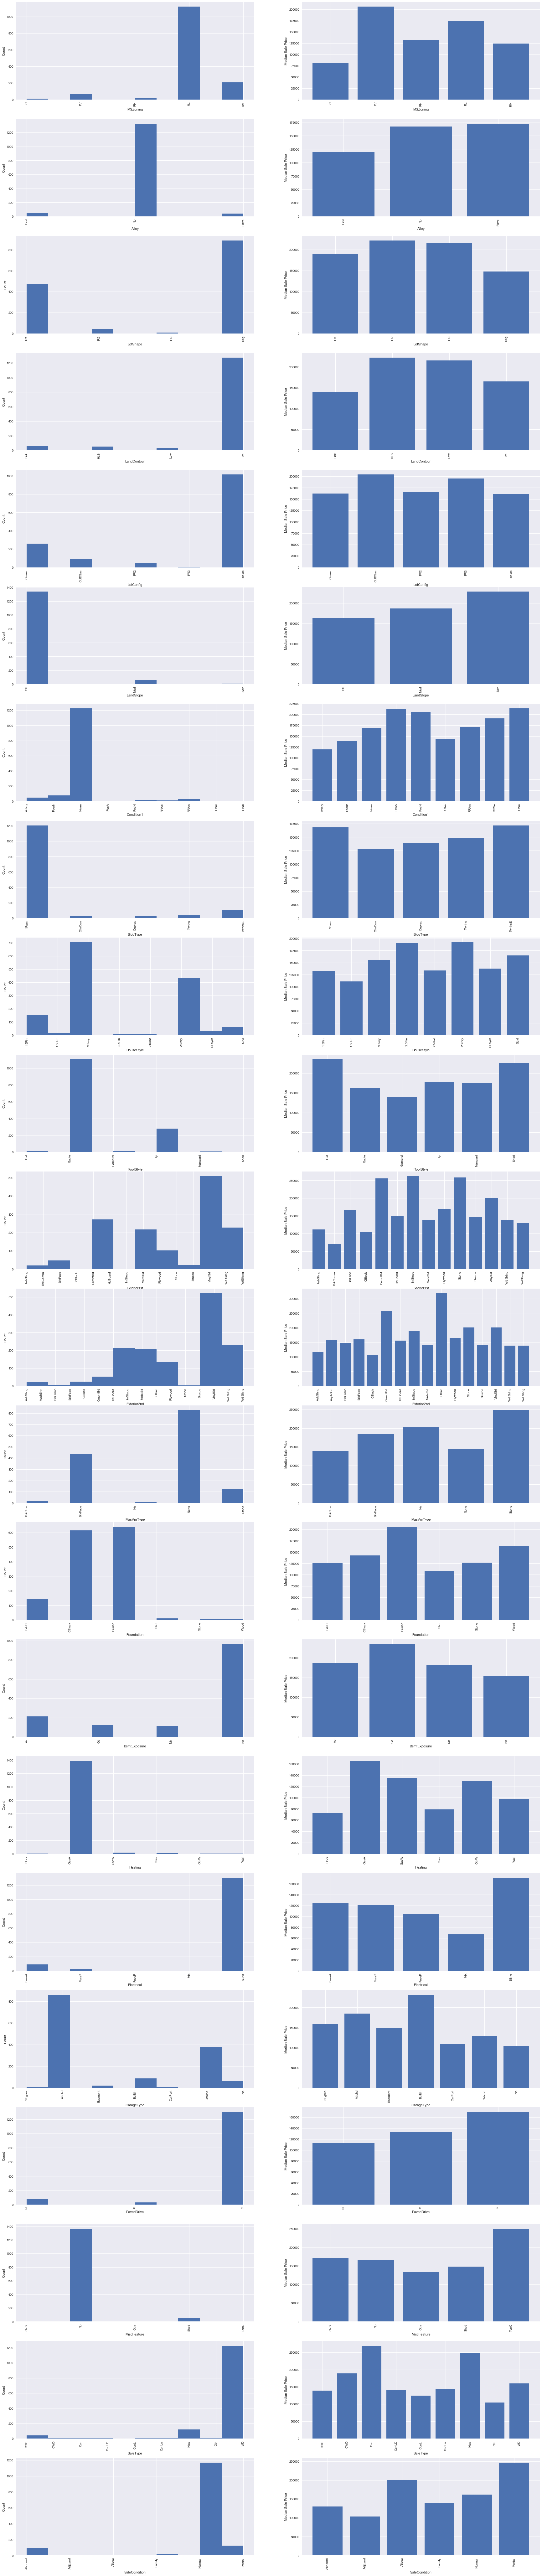

In [188]:
# analyze rest 22 cols by distribution and impact on sale price.
graphRows = len(catTrainNew)
plt.figure(figsize = (30,150))
i = 1
#trainRaw = pd.read_csv('train_0N.csv')
for col in catTrainNew:
    
    plt.subplot(graphRows, 2, i)
    i+=1
    plt.hist(train[col])
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.xticks(rotation=90)
    
    plt.subplot(graphRows, 2, i)
    i+=1
    #plt.hist(train['MSZoning'])
    conditionPivot = train.pivot_table(index=col, values='SalePrice', aggfunc=np.median)
    plt.bar(conditionPivot.index, conditionPivot['SalePrice'])
    plt.ylabel('Median Sale Price')
    plt.xlabel(col)
    plt.xticks(rotation=90)


### Order according to the graph shown above

In [189]:
np.unique(train['Exterior1st'])
# {'1.5f':3}
# HouseStyle     7
# Exterior1st    3
# Exterior2nd    1
# Heating        2
# Electrical     1
# MiscFeature    1
print(train['Exterior1st'].value_counts())
print(test['Exterior1st'].value_counts())



VinylSd    508
HdBoard    219
MetalSd    216
Wd Sdng    202
Plywood    100
CemntBd     53
BrkFace     47
WdShing     25
Stucco      22
AsbShng     17
Stone        2
BrkComm      2
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64
VinylSd    511
MetalSd    230
HdBoard    220
Wd Sdng    205
Plywood    113
CemntBd     65
BrkFace     37
WdShing     30
AsbShng     24
Stucco      18
BrkComm      4
AsphShn      1
CBlock       1
Name: Exterior1st, dtype: int64


In [190]:
train['2Materials'] = (train['Exterior2nd']!=train['Exterior1st']).astype(int)
test['2Materials'] = (test['Exterior2nd']!=test['Exterior1st']).astype(int)
# Construct nominal to level dict from graph above.
MSZoningDict = dict(zip(np.unique(train['MSZoning']),[1,3,2,3,2]))
AlleyDict = dict(zip(np.unique(train['Alley']),[1,2,2]))
LotShapeDict = dict(zip(np.unique(train['LotShape']),[2,2,2,1]))
LandContourDict = dict(zip(np.unique(train['LandContour']),[1,4,3,2]))
LotConfigDict = dict(zip(np.unique(train['LotConfig']),[1,2,1,2,1]))
LandSlopeDict = dict(zip(np.unique(train['LandSlope']),[1,2,2]))
Condition1Dict = dict(zip(np.unique(train['Condition1']),[1,2,3,4,4,2,3,4,4]))
BldgTypeDict = dict(zip(np.unique(train['BldgType']),[2,1,1,1,2]))
HouseStyleDict = dict(zip(np.unique(train['HouseStyle']),[2,1,3,4,2,4,2,3]))
RoofStyleDict = dict(zip(np.unique(train['RoofStyle']),[3,2,1,3,3,4]))
Exterior1stDict = dict(zip(np.unique(train['Exterior1st']),[2,2,1,3,2,4,3,4,3,3,4,3,4,3,3]))
Exterior2ndDict = dict(zip(np.unique(train['Exterior2nd']),[1,2,2,2,1,3,2,2,2,4,2,2,2,2,2,2]))
MasVnrTypeDict = dict(zip(np.unique(train['MasVnrType']),[1,2,2,1,3]))
FoundationDict = dict(zip(np.unique(train['Foundation']),[1,1,3,1,1,2]))
BsmtExposureDict = dict(zip(np.unique(train['BsmtExposure']),[2,3,2,1]))
HeatingDict = dict(zip(np.unique(train['Heating']),[1,3,2,1,2,1]))
ElectricalDict = dict(zip(np.unique(train['Electrical']),[2,2,1,1,3]))
GarageTypeDict = dict(zip(np.unique(train['GarageType']),[2,2,2,3,1,1,1]))
PavedDriveDict = dict(zip(np.unique(train['PavedDrive']),[1,2,3]))
MiscFeatureDict = dict(zip(np.unique(train['MiscFeature']),[2,2,1,2,3]))
SaleTypeDict = dict(zip(np.unique(train['SaleType']),[1,2,3,1,1,1,3,1,2]))
SaleConditionDict = dict(zip(np.unique(train['SaleCondition']),[1,1,1,1,1,2]))
Exterior1stDict['AsphShn'] =1
nomiToLevelDict = [MSZoningDict,AlleyDict, LotShapeDict, LandContourDict, LotConfigDict, LandSlopeDict,
                  Condition1Dict, BldgTypeDict, HouseStyleDict, RoofStyleDict, Exterior1stDict,
                  Exterior2ndDict, MasVnrTypeDict, FoundationDict, BsmtExposureDict, HeatingDict,
                  ElectricalDict, GarageTypeDict, PavedDriveDict, MiscFeatureDict, SaleTypeDict, SaleConditionDict]

### These 22 attributes can be decomposed: appearance dominant + impact dominant

In [191]:
def encodeFreqMore200(train,test,cols):
    newLabels = []
    if train.empty or test.empty or not cols:
        return "Error, none input"
    else:
        for col in cols:
            tempDict = train[col].value_counts().to_dict()
            for key, value in tempDict.items():
                if value >= 200:
                    newLabels.append((col+'_'+key))
                    train[(col+'_'+key)] = train[col].apply(lambda x: 1 if x == key else 0)
                    test[(col+'_'+key)] = test[col].apply(lambda x: 1 if x == key else 0)
        return newLabels

# Encode the ones shown more than 200 times.
newLabels = encodeFreqMore200(train, test, catTrainNew)
# len(newLabels) = 36
# train.shape 69 ->105



In [192]:
def codeToLevelDict(df, ordCols, codeToLevelDicts):
    for i, col in enumerate(ordCols):
        if np.issubdtype(df[col].dtype, np.number):
            pass
        else:
            df[col] = df[col].map(codeToLevelDicts[i])
            
# Convert
codeToLevelDict(train, catTrainNew, nomiToLevelDict)
codeToLevelDict(test, catTrainNew, nomiToLevelDict)

# np.unique(test.dtypes) only have numerical data

In [193]:
checkNull(test)
checkNull(train)

'The dataframe is NA free. Contains 1415 rows with 105 attributes'

### Lastly, the 'MSSubClass' is a pitfall, watch out the 150 did not show at all in the training set.

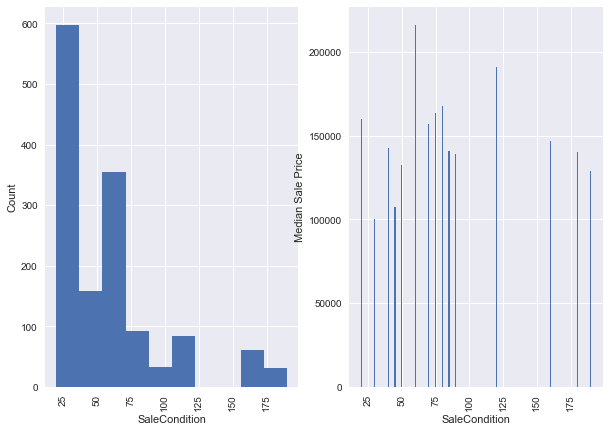

In [194]:
# The MSSubClass needs extra care.
plt.figure(figsize = (10,7))
plt.subplot(1, 2, 1)
plt.hist(train['MSSubClass'])
plt.ylabel('Count')
plt.xlabel(col)
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
conditionPivot = train.pivot_table(index='MSSubClass', values='SalePrice', aggfunc=np.median)
plt.bar(conditionPivot.index, conditionPivot['SalePrice'])
plt.ylabel('Median Sale Price')
plt.xlabel(col)
plt.xticks(rotation=90)

# here dummy is the best choice
train['MSSubClass'] = train['MSSubClass'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)

# get dummy
train = pd.get_dummies(train, prefix = ['MSSubClass'])
test = pd.get_dummies(test, prefix = ['MSSubClass'])

# missing 150
train['MSSubClass_150'] = 0

## Now all data are numerical. For reasonable positive skewed attributes, apply log transform.

In [195]:
checkNull(test)
checkNull(train)

'The dataframe is NA free. Contains 1415 rows with 120 attributes'

In [196]:
numericColsSkewRAW = numericColsSkew
highSkewIndex = numericColsSkewRAW[numericColsSkewRAW>0.8].index
print(highSkewIndex)

trainLog=train.copy()
testLog =test.copy()

def logTansform(df, cols):
    result = df
    for col in cols:
        if col in result:
            result[col] = np.log1p(result[col])
    return result

# log-transform approach 1: only transfor ORIGINAL NUMERICAL with SKEW > 0.8
trainLog = logTansform(trainLog, highSkewIndex)
testLog = logTansform(testLog, highSkewIndex)

print(train.shape, test.shape)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'Kitchen', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'SalePrice'],
      dtype='object')
(1415, 120) (1459, 119)


### Now the data is very dense, free of outliers, normally distributed. Ready for the next step analysis!

In [197]:
def putPriceEnd(df):
    temp = df['SalePrice']
    df.drop(['SalePrice'],  axis = 1, inplace = True)
    df['SalePrice'] = temp
    return df
list1 = [train, trainLog]

for i in list1:
    i = putPriceEnd(i)

In [198]:
train

,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_150,SalePrice
0,3,65.0,8450,2,1,2,1,1,197200.0,3,...,0,0,1,0,0,0,0,0,0,208500
1,3,80.0,9600,2,1,2,1,1,206000.0,2,...,0,0,0,0,0,0,0,0,0,181500
2,3,68.0,11250,2,2,2,1,1,197200.0,3,...,0,0,1,0,0,0,0,0,0,223500
3,3,60.0,9550,2,2,2,1,1,200624.0,3,...,0,0,0,1,0,0,0,0,0,140000
4,3,84.0,14260,2,2,2,1,1,301500.0,3,...,0,0,1,0,0,0,0,0,0,250000
5,3,85.0,14115,2,2,2,1,1,154750.0,3,...,0,1,0,0,0,0,0,0,0,143000
6,3,75.0,10084,2,1,2,1,1,225500.0,3,...,0,0,0,0,0,0,0,0,0,307000
7,3,69.0,10382,2,2,2,1,1,182900.0,4,...,0,0,1,0,0,0,0,0,0,200000
8,2,51.0,6120,2,1,2,1,1,118250.0,1,...,0,1,0,0,0,0,0,0,0,129900
9,3,50.0,7420,2,1,2,1,1,127000.0,1,...,0,0,0,0,0,0,0,0,0,118000


In [200]:
# Save
train.to_csv("train_120feats_Dense_OutlierFree_NoTransform.csv", index=False)
test.to_csv("test_119feats_Dense_OutlierFree_NoTransform.csv", index=False)
trainLog.to_csv("train_120feats_Dense_OutlierFree_LogTransform.csv", index=False)
testLog.to_csv("test_119feats_Dense_OutlierFree_LogTransform.csv", index=False)


In [142]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.stats import gaussian_kde
from scipy import stats
from scipy.spatial.distance import cdist, pdist, euclidean
from sklearn.decomposition import PCA
def putClusterIndex(df, nCluster = 2, method = "KMeans"):
    # PCA stage
        # Copy salePrice and save it somewhere else
    salePriceCol = df['SalePrice'].copy()
    df.drop(['SalePrice'], axis = 1, inplace = True)
        #  Scale the rest cols
    trainMatrix = df.as_matrix()
    trainMatrix = preprocessing.scale(trainMatrix)
    dfPCA = PCA(n_components=60).fit_transform(train) 
    
    # Clustering stage
        # Perform clustering 
    if method == 'KMeans':
        clusterResult = KMeans(n_clusters=2, init='k-means++', n_init=50, max_iter=2000).fit(dfPCA)
    if method == 'Agglo':
        clusterResult = AgglomerativeClustering(n_clusters=2).fit(dfPCA) 
        # Add cluster indexes to the dataframe
    df['Clusterlabel'] = clusterResult.labels_
    
    # Data output prepare
        # Create add price back to the df
    df['SalePrice'] = salePriceCol
        # Split the clusters
    trainCluster0 = df[df['Clusterlabel']==0].copy()
    trainCluster1 = df[df['Clusterlabel']==1].copy()
        # Drop Cluster labels
    trainCluster0.drop(['Clusterlabel'], axis = 1, inplace = True)
    trainCluster1.drop(['Clusterlabel'], axis = 1, inplace = True)
        # Get count of points
    print("{0} points in Cluster #1 and {1} points in Cluster #2".format(trainCluster0.shape[0], trainCluster1.shape[0]))
        # Save the files to local
    trainCluster0.to_csv(method+"_0_train_120feats_Dense_OutlierFree_NoTransform.csv")
    trainCluster1.to_csv(method+"_1_train_120feats_Dense_OutlierFree_NoTransform.csv")

In [145]:
putClusterIndex(trainLog, nCluster = 2, method = "KMeans")
putClusterIndex(trainLog, nCluster = 2, method = "Agglo")

1059 points in Cluster #1 and 356 points in Cluster #2
771 points in Cluster #1 and 644 points in Cluster #2


# Time Series Analysis
1. There is some interesting trend can be observed.
2. Raw median plot did not show any useful info, but once decomposite as a TS, we can clearly observe the 08 breakdown.
3. However, the market did not seem to recover back as the rest of US, this is probably due to rural place did not recover as fast as big cities.

In [60]:
target1 = ['MoSold','YrSold','LotArea','GrLivArea']
def testConsistency(df,target):
    tsDF = df[target].copy()
    tsDF['Month'] = tsDF['YrSold'].astype('str')+'-'+tsDF['MoSold'].astype('str')
    tsDF['Month'] = pd.to_datetime(tsDF['Month'])
    tsDF.sort_values(by = 'Month', inplace = True)
    tsDFLotArea = tsDF["LotArea"].groupby(tsDF["Month"]).median()
    tsDFGrLivArea = tsDF["GrLivArea"].groupby(tsDF["Month"]).median()
    #tsDF.set_index('Month', inplace = True)
    #tsDF.drop(['MoSold', 'YrSold'], axis = 1, inplace = True)
    # Get median
    result1 = pd.DataFrame(tsDFLotArea)
    result2 = pd.DataFrame(tsDFGrLivArea)
    return result1, result2


In [61]:
tsDFLotArea, tsDFGrLivArea = testConsistency(train, target1)

In [71]:
tsDFGrLivArea.std()/tsDFGrLivArea.mean()

GrLivArea    0.103015
dtype: float64

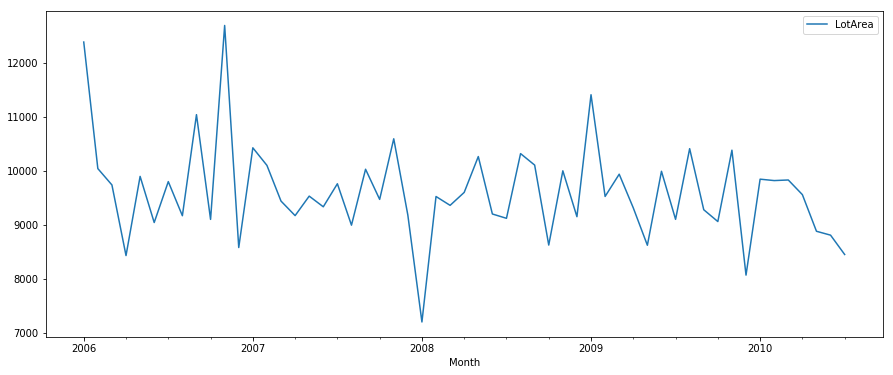

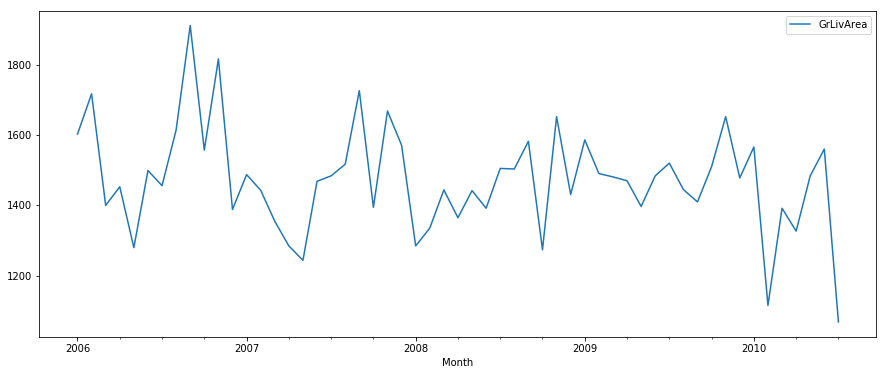

In [62]:
tsDFLotArea.plot(figsize=(15, 6))
tsDFGrLivArea.plot(figsize=(15, 6))

In [67]:
# Massage Data
target = ['MoSold','YrSold','SalePrice']
# tsDF = train[target].copy()
# tsDF['Month'] = tsDF['YrSold'].astype('str')+'-'+tsDF['MoSold'].astype('str')
# tsDF['Month'] = pd.to_datetime(tsDF['Month'])
# #tsDF['Time'] = pd.to_datetime(dict(year=tsDF.YrSold, month=tsDF.MoSold, day=15), format="%Y%m%d")
# tsDF.sort_values(by = 'Month', inplace = True)
# tsDFMedian = tsDF["SalePrice"].groupby(tsDF["Month"]).median()
# tsDF.set_index('Month', inplace = True)
# tsDF.drop(['MoSold', 'YrSold'], axis = 1, inplace = True)
# # Get median
# tsPLOT = pd.DataFrame(tsDFMedian)

def getTSdf(df, target):
    tsDF = df[target].copy()
    tsDF['Month'] = tsDF['YrSold'].astype('str')+'-'+tsDF['MoSold'].astype('str')
    tsDF['Month'] = pd.to_datetime(tsDF['Month'])
    tsDF.sort_values(by = 'Month', inplace = True)
    tsDFMedian = tsDF["SalePrice"].groupby(tsDF["Month"]).median()
    #tsDF.set_index('Month', inplace = True)
    #tsDF.drop(['MoSold', 'YrSold'], axis = 1, inplace = True)
    # Get median
    result = pd.DataFrame(tsDFMedian)
    return result
    
originalTS = getTSdf(train, target)
logTS = getTSdf(trainLog, target)

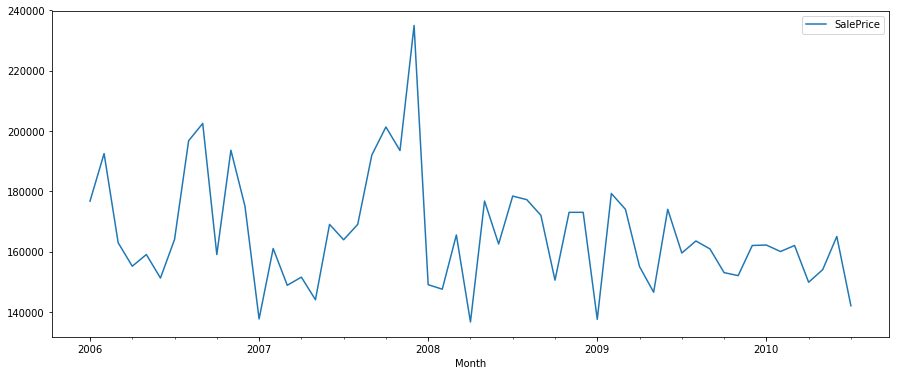

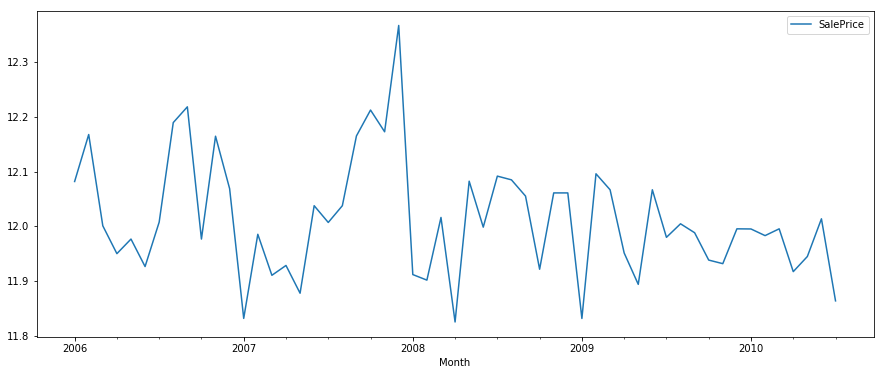

In [78]:
originalTS.plot(figsize=(15, 6))
plt.show()
logTS.plot(figsize=(15, 6))
plt.show()

In [79]:
originalTS.std()/originalTS.mean()

SalePrice    0.113216
dtype: float64

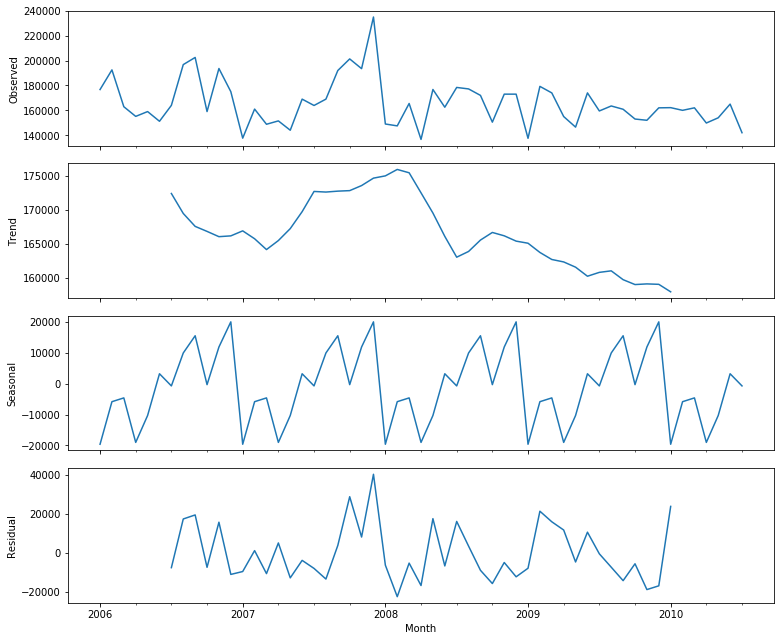

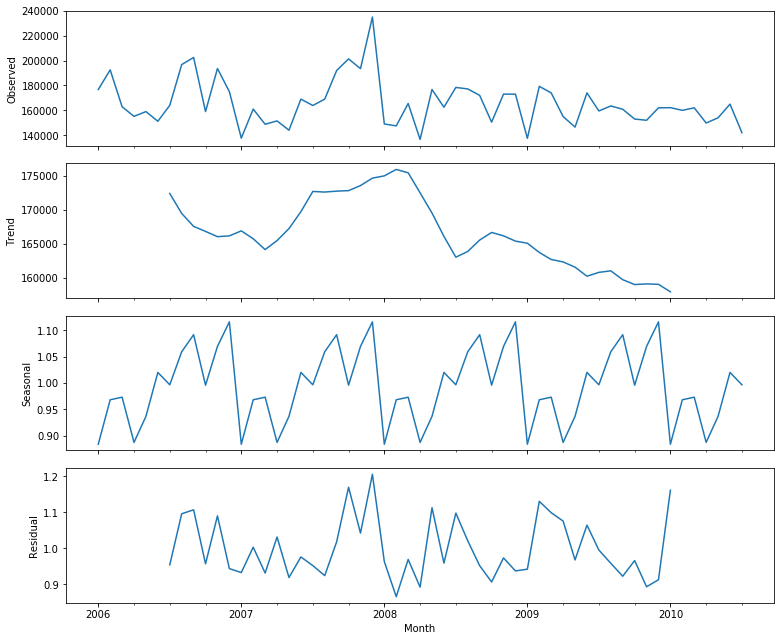

In [80]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(originalTS, model='additive')
fig = decomposition.plot()
plt.show()
decomposition = sm.tsa.seasonal_decompose(originalTS, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [81]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://news.medill.northwestern.edu/chicago/wp-content/uploads/sites/3/2016/01/Screen-Shot-2016-01-26-at-12.54.26-PM.png", width=500, height=500)

In [82]:
# Uncomment to see break down.
decomposition.trend

,SalePrice
Month,
2006-01-01,NaN
2006-02-01,NaN
2006-03-01,NaN
2006-04-01,NaN
2006-05-01,NaN
2006-06-01,NaN
2006-07-01,172394.375000
2006-08-01,169453.750000
2006-09-01,167553.750000


In [83]:
temp = decomposition.trend
temp.std()/temp.mean()

SalePrice    0.030672
dtype: float64

# PCA
1. with the new dense data, we can be more confident to perform PCA.

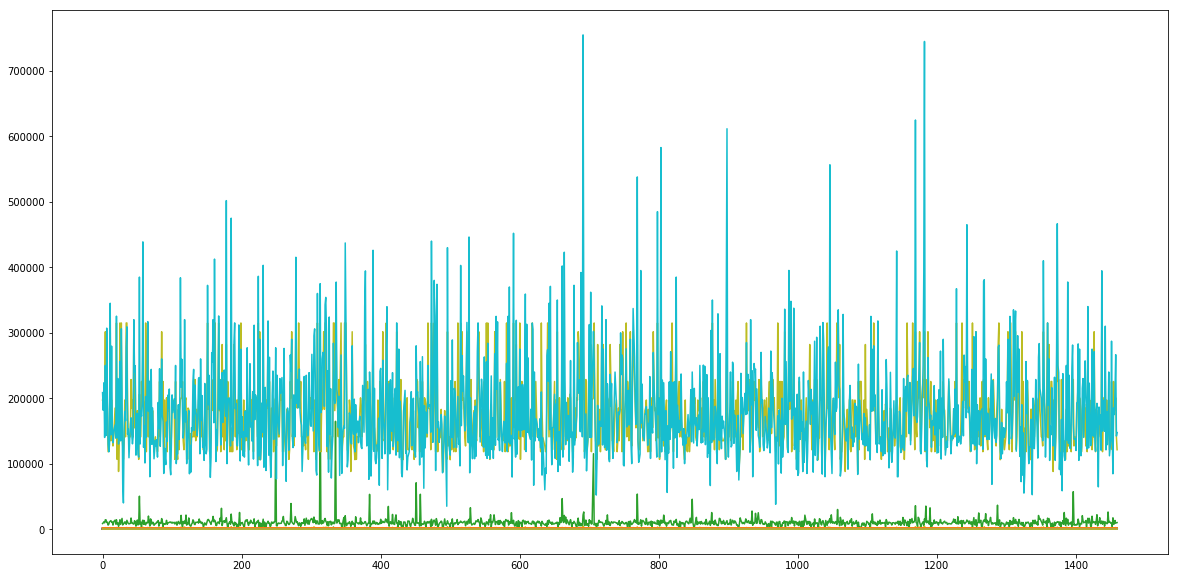

In [84]:
train.plot(figsize=(20,10), legend = False)
# Terrible scales....

In [85]:
checkNull(train)
train.drop(['SalePrice'], axis = 1, inplace = True)

# Normalize the data.
trainMatrix = train.as_matrix()
trainMatrix = preprocessing.scale(trainMatrix)

# Perform PCA. 
from sklearn.decomposition import PCA
pca = PCA().fit(trainMatrix)

# Get incremental and cumulative viariance explained by PCA.
incr_var_expl = pca.explained_variance_ratio_
tot_var_expl = np.array([sum(incr_var_expl[0:i+1]) for i,x in enumerate(incr_var_expl)]) 

# Plot out the result.
plt.figure(figsize=(8,8))
plt.plot(range(1,len(tot_var_expl)+1), tot_var_expl*100,'o-')
plt.axis([0, len(tot_var_expl)+1, 20, 110])
plt.xlabel('Cumulative PCA Components')
plt.ylabel('% Variance Explained')

plt.figure(figsize=(8,8))
plt.plot(range(1,len(incr_var_expl)+1), incr_var_expl*100,'o-')
plt.axis([0, len(incr_var_expl)+1, -1, 40])
plt.xlabel('PCA Component')
plt.ylabel('% Variance Explained')

In [88]:
# Put the PCA results into a dataframe, construct another heatmap. 
PCA_df = pd.DataFrame(pca.components_, columns=train.columns)
Components = pd.Series(('C. '+ str(i+1)) for i in range(20)) 
PCA_df['Components'] = Components
PCA_df = PCA_df.set_index(['Components'])

# Plot a heat map of the correlations. 
sns.set(font_scale = 1)
fig, ax = plt.subplots(figsize=(300,200))         # Sample figsize in inches

#sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(PCA_df.iloc[0:15, :], square=True, annot=True, annot_kws={"size": 10}, ax=ax, linewidths=2, cbar_kws={"orientation": "vertical"}
).xaxis.tick_top()
#indexed_data2 = data2.set_index(['Player'])

# Clustering 

In [89]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.stats import gaussian_kde
from scipy import stats
from scipy.spatial.distance import cdist, pdist, euclidean

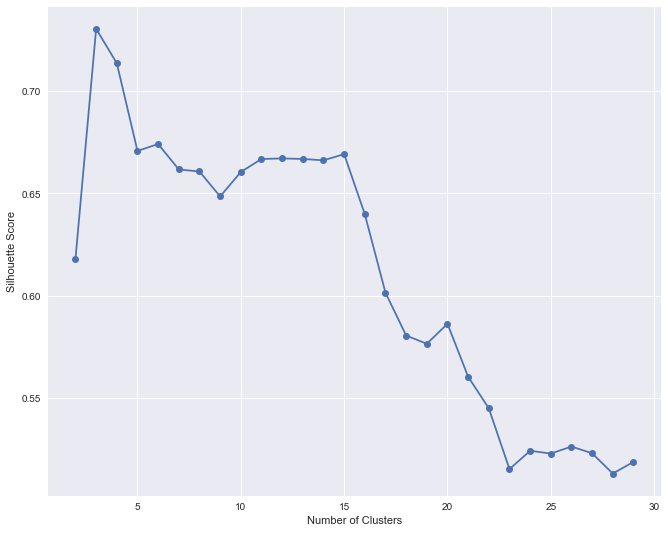

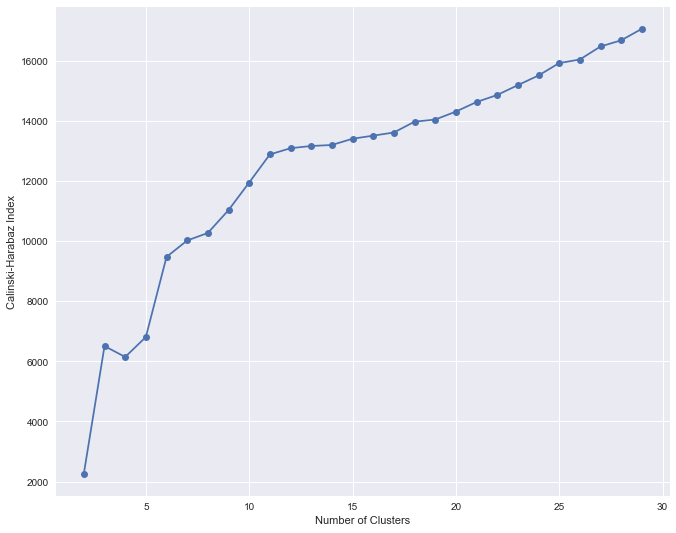

In [93]:
# Determine how many clusters to use by use Silhouette Score and Calinski-Harabaz Index.

# Reduce dimension from 120 to 60
full_dataset_after_PCA = PCA(n_components=60).fit_transform(train) 

# Will test from 2 clusters to 30 clusters
clusters = range(2,30)

# Create K-mean clustering 
fit_results_list = []
for i in clusters:
    fit_result = KMeans(n_clusters=i, init='k-means++', n_init=50, max_iter=2000).fit(full_dataset_after_PCA)
    fit_results_list.append(fit_result)

# Calculate silhouette score and 
sil_score_list = []
calinski_harabaz_score_list = []
for item in fit_results_list:
    label = item.labels_
    sil_score = metrics.silhouette_score(full_dataset_after_PCA,label, metric='euclidean')
    calinski_harabaz_score = metrics.calinski_harabaz_score(full_dataset_after_PCA,label)  
    sil_score_list.append(sil_score)
    calinski_harabaz_score_list.append(calinski_harabaz_score)

plt.figure(1)
plt.plot(clusters, sil_score_list,'o-')
#plt.axis([1, 28, 0.1, 0.4])
plt.xlabel('Number of Clusters');
plt.ylabel('Silhouette Score');

plt.figure(2)
plt.plot(clusters, calinski_harabaz_score_list,'o-')
#plt.axis([1, 28, 20, 50])
plt.xlabel('Number of Clusters');
plt.ylabel('Calinski-Harabaz Index');

In [97]:
sil_score_list
# K-mean, fit data to 5 clusters
final_fit_K_means = KMeans(n_clusters=2, init='k-means++', n_init=50, max_iter=2000).fit(full_dataset_after_PCA) 

train['kmeans_label'] = final_fit_K_means.labels_

trainCluster0 = train[train['kmeans_label']==0]
trainCluster1 = train[train['kmeans_label']==1]

In [109]:
trainCluster1.shape

(727, 120)

/Users/roger/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


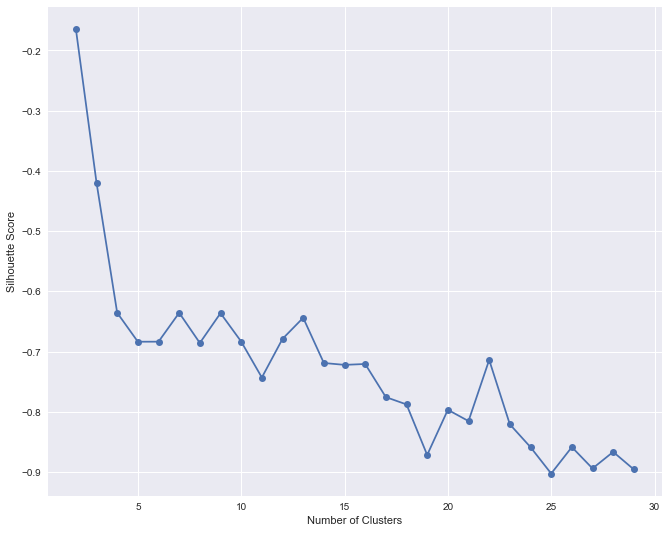

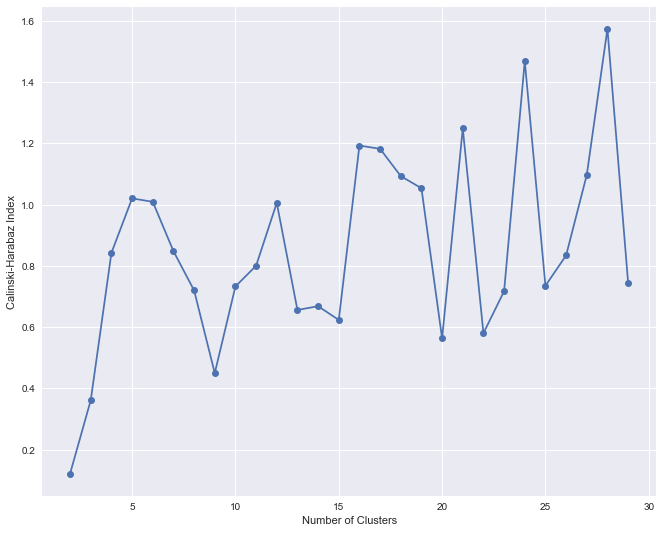

In [91]:
#from sklearn.cluster import SpectralClustering

# Determine how many clusters to use by use Silhouette Score and Calinski-Harabaz Index.

# Reduce dimension from 120 to 60
full_dataset_after_PCA = PCA(n_components=60).fit_transform(train) 

# Will test from 2 clusters to 30 clusters
clusters = range(2,30)

# Create K-mean clustering 
fit_results_list = []
for i in clusters:
    fit = SpectralClustering(n_clusters=i).fit(full_dataset_after_PCA) 
    fit_results_list.append(fit)

# Calculate silhouette score and 
sil_score_list = []
calinski_harabaz_score_list = []
for item in fit_results_list:
    label = item.labels_
    sil_score = metrics.silhouette_score(full_dataset_after_PCA,label, metric='euclidean')
    calinski_harabaz_score = metrics.calinski_harabaz_score(full_dataset_after_PCA,label)  
    sil_score_list.append(sil_score)
    calinski_harabaz_score_list.append(calinski_harabaz_score)

plt.figure(1)
plt.plot(clusters, sil_score_list,'o-')
#plt.axis([1, 28, 0.1, 0.4])
plt.xlabel('Number of Clusters');
plt.ylabel('Silhouette Score');

plt.figure(2)
plt.plot(clusters, calinski_harabaz_score_list,'o-')
#plt.axis([1, 28, 20, 50])
plt.xlabel('Number of Clusters');
plt.ylabel('Calinski-Harabaz Index');

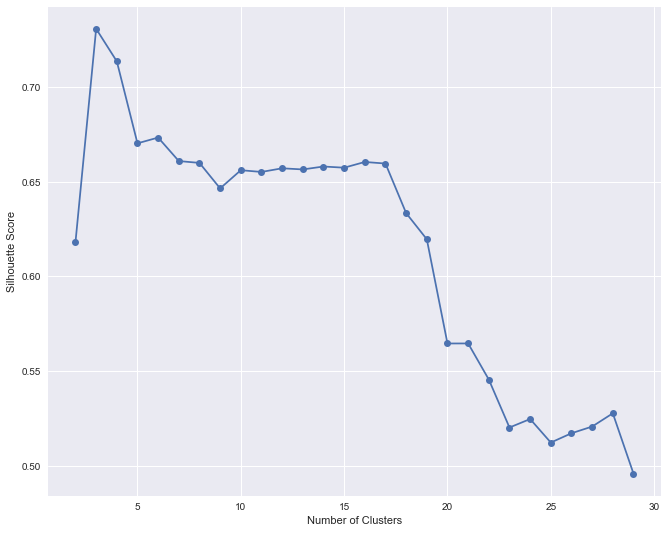

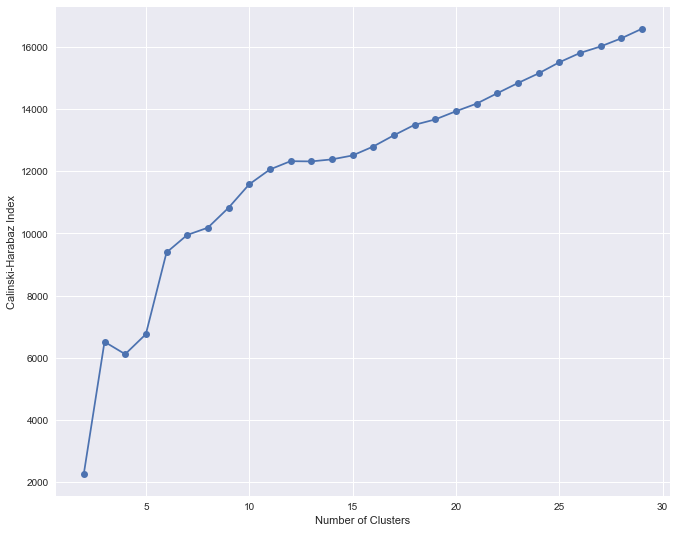

In [92]:
#from sklearn.cluster import AgglomerativeClustering
# Determine how many clusters to use by use Silhouette Score and Calinski-Harabaz Index.

# Reduce dimension from 120 to 60
full_dataset_after_PCA = PCA(n_components=60).fit_transform(train) 

# Will test from 2 clusters to 30 clusters
clusters = range(2,30)

# Create K-mean clustering 
fit_results_list = []
for i in clusters:
    fit = AgglomerativeClustering(n_clusters=i).fit(full_dataset_after_PCA) 
    fit_results_list.append(fit)

# Calculate silhouette score and 
sil_score_list = []
calinski_harabaz_score_list = []
for item in fit_results_list:
    label = item.labels_
    sil_score = metrics.silhouette_score(full_dataset_after_PCA,label, metric='euclidean')
    calinski_harabaz_score = metrics.calinski_harabaz_score(full_dataset_after_PCA,label)  
    sil_score_list.append(sil_score)
    calinski_harabaz_score_list.append(calinski_harabaz_score)

plt.figure(1)
plt.plot(clusters, sil_score_list,'o-')
#plt.axis([1, 28, 0.1, 0.4])
plt.xlabel('Number of Clusters');
plt.ylabel('Silhouette Score');

plt.figure(2)
plt.plot(clusters, calinski_harabaz_score_list,'o-')
#plt.axis([1, 28, 20, 50])
plt.xlabel('Number of Clusters');
plt.ylabel('Calinski-Harabaz Index');